In [1]:
import pandas as pd
import os
import json
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.grid_search import GridSearchCV
from collections import defaultdict
import cPickle as pickle
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib inline

In [63]:
# function to extract information from the json files
def json_extract(file):
    with open('data/{}'.format(file)) as f:
        data = json.load(f)
        cols = data['resultSets'][0]['headers']
        vals = data['resultSets'][0]['rowSet']
    return cols, vals


# function to create dataframe from the json information
# keyword = gamelog, season_stats, or heights_weights
def create_df(keyword, add_year=False):

    fns = os.listdir('data/')

    cols = json_extract('2013_{}.json'.format(keyword))[0]
    if add_year:
        cols += ['YEAR']
    df = pd.DataFrame(columns=cols)

    for fn in fns:
        if keyword in fn:
            tmp_cols, tmp_vals = json_extract(fn)
            df_tmp = pd.DataFrame(tmp_vals, columns=tmp_cols)
            if add_year:
                df_tmp['YEAR'] = int(fn[0:4])
            df = df.append(df_tmp)
            del df_tmp, tmp_cols, tmp_vals
    return df


def parse_date(df, date_col, create_sep_cols=True):

    df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True)
    if create_sep_cols:
        date = df[date_col]
        df['YEAR'] = date.apply(lambda x: x.year)
        df['MONTH'] = date.apply(lambda x: x.month)
        df['DAY'] = date.apply(lambda x: x.day)

    return df


def clean_notes(x):
    found = re.findall(r'\s\(\w\)', x)
    if found:
        return x.replace(found[0], '')
    else:
        return x

    
# preprocess injury df
def prep_injury(df):

    drop_vars = ['Unnamed: 0', 'Team']
    df.drop(drop_vars, axis=1, inplace=True)
    
    # converting the Date column to datetime objects
    df = parse_date(df, 'Date')
#     df['Date'] = pd.to_datetime(df['Date'])

    # filter out all events not directly related to basketball
    df = df[(~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('rest')) &
            (~df['Notes'].str.contains('jail')) &
            (~df['Notes'].str.contains('ill')) &
            (~df['Notes'].str.contains('asthma')) &
            (~df['Notes'].str.contains('virus')) &
            (~df['Notes'].str.contains('return')) &
            (~df['Notes'].str.contains('pneumonia')) &
            (~df['Notes'].str.contains('coach')) &
            (~df['Notes'].str.contains('sister')) &
            (~df['Notes'].str.contains('Fined')) &
            (~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('GM')) &
            (~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('team')) &
            (~df['Notes'].str.contains('canal')) &
            (~df['Notes'].str.contains('food')) &
            (~df['Notes'].str.contains('virus')) &
            (~df['Notes'].str.contains('wife')) &
            (~df['Notes'].str.contains('asthma')) &
            (~df['Notes'].str.contains('chin')) &
            (~df['Notes'].str.contains('headache')) &
            (~df['Notes'].str.contains('anemia')) &
            (~df['Notes'].str.contains('dizziness')) &
            (~df['Notes'].str.contains('cold')) &
            (~df['Notes'].str.contains('throat')) &
            (~df['Notes'].str.contains('molar')) &
            (~df['Notes'].str.contains('dizziness')) &
            (~df['Notes'].str.contains('rash')) &
            (~df['Notes'].str.contains('stomach ache')) &
            (~df['Notes'].str.contains('bronchitis')) &
            (~df['Notes'].str.contains('concussion')) &
            (~df['Notes'].str.contains('recover')) &
            (~df['Notes'].str.contains('mump'))]

    # clean notes
    df['Notes'] = df['Notes'].apply(clean_notes)
    
    # stripping blank spaces from player names
    df['Player'] = df['Player'].apply(lambda x: x.strip())
    
    # removing periods from names like C.J.
    df['Player'] = df['Player'].apply(lambda x: ''.join(x.split('.')) if re.match(r'\w\.\w\.', x) else x)
    
    # removing characters like (a) and (b)
    df['Player'] = df['Player'].apply(lambda x: ' '.join(x.split()[:2]) if re.match(r'.+\(.+\)', x) else x)
    
    df[df['Player'] == '(William) Tony Parker']['Player'] = 'Tony Parker'
    df = df[df['Player'] != '']

    unique_players = gamelog_df['PLAYER_NAME'].unique()
    for player in unique_players:
        df['Player'] = df['Player'].apply(lambda x: player if player in x else x)

    return df


# preprocess
def prep_gamelog(df):

    # converting the Date column to datetime objects
    df = parse_date(df, 'GAME_DATE')

    drop_vars = ['SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
                 'WL', 'FG_PCT', 'FG3_PCT', 'FT_PCT',
                 'VIDEO_AVAILABLE']
    df.drop(drop_vars, axis=1, inplace=True)

    return df


def start_end_season(keyword, add_year=False):

    fns = os.listdir('data/')
    cols = json_extract('2013_{}.json'.format(keyword))[0]
    if add_year:
        cols += ['YEAR']
    df = pd.DataFrame(columns=cols)

    season_range = []
    for fn in fns:
        if keyword in fn:
            cols, vals = json_extract(fn)
            df = pd.DataFrame(vals, columns=cols)
            season_range.append((datetime.strptime(df['GAME_DATE'].min(), '%Y-%m-%d'),
                                 datetime.strptime(df['GAME_DATE'].max(), '%Y-%m-%d')))            
    return season_range


def create_feat_mat(df, data_window=21):
    feat_mat = pd.DataFrame()
    player_id = df['PLAYER_ID'].unique().tolist()
    for id in player_id:
        tmp = df[df['PLAYER_ID'] == id]
        roll_mean_df = pd.rolling_mean(tmp, data_window)
        feat_mat = feat_mat.append(roll_mean_df)
    return feat_mat


def pickles_to_pandas(keyword, add_year=False):
    
    fns = os.listdir('data/')
    with open('data/2014_{}_stats.pickle'.format(keyword), 'r') as f:
        pkl_f = pickle.load(f)
        cols = pkl_f[0]['resultSets'][0]['headers']
    df = pd.DataFrame(columns=cols)
    for fn in fns:
        if keyword in fn:
            with open('data/{}'.format(fn), 'r') as f:
                pkl_f = pickle.load(f)
            for item in pkl_f:
                tmp_cols = item['resultSets'][0]['headers']
                tmp_vals = item['resultSets'][0]['rowSet']
                df_tmp = pd.DataFrame(tmp_vals, columns=tmp_cols)
                if add_year:
                    df_tmp['YEAR'] = int(fn[0:4])
                df = df.append(df_tmp)
                del df_tmp, tmp_cols, tmp_vals
    return df
        
    
def shuffle_rows(df):
  return df.reindex(np.random.permutation(df.index))

def pace_tracking(keep_cols, keyword):
    df = pickles_to_pandas(keyword, add_year=True)
    df.drop(df.columns - keep_cols, axis=1, inplace=True)
    df.rename(columns={'GAME_ID': 'GAME_ID_{}'.format(keyword.upper()),
                     'PLAYER_NAME': 'PLAYER_NAME_{}'.format(keyword.upper()),
                     'PLAYER_ID': 'PLAYER_ID_{}'.format(keyword.upper()),
                     'YEAR': 'YEAR_{}'.format(keyword.upper())},
              inplace=True) 
    return df

def game_loc(x):
    if 'vs.' in x:
        return city_abbrv[re.split(r' vs. ', x)[0]]
    elif '@' in x:
        return city_abbrv[re.split(r' @ ', x)[1]]

In [4]:
with open('feat_mat.pickle', 'r') as f:
    feat_mat = pickle.load(f)

with open('merged.pickle', 'r') as f:
    merged = pickle.load(f)

In [66]:
ss_df = create_df('season_stats', add_year=True)
hw_df = create_df('heights_weights', add_year=True)
gamelog_df = create_df('gamelog')
gamelog_df = prep_gamelog(gamelog_df)
injury_df = pd.read_csv('data/injuries.csv')
injury_df = prep_injury(injury_df)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [4]:
pd.options.display.max_columns = 100

In [67]:
gamelog = gamelog_df
injury = injury_df

In [68]:
start_data = datetime.strptime('10-29-2013', '%m-%d-%Y')
gamelog = gamelog[gamelog['GAME_DATE'] >= start_data]
injury = injury[injury['Date'] >= start_data]
hw_df = hw_df[hw_df['YEAR'] >= 2013]
injury.rename(columns={'Player':'Player_Injury',
                       'Date': 'Date_Injury'
                      },
              inplace=True)

/home/peter/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [12]:
pace_keep_cols = ['GAME_ID', 'PACE', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
tracking_keep_cols = ['GAME_ID', 'SPD', 'DIST', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
  
tracking = pace_tracking(tracking_keep_cols, 'tracking')
pace = pace_tracking(pace_keep_cols, 'pace')

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [ ]:
# pace = pickles_to_pandas('pace', add_year=True)
# pace_keep_cols = ['GAME_ID', 'PACE', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
# pace_drop_cols = pace.columns - pace_keep_cols
# pace.drop(pace_drop_cols, axis=1, inplace=True)
# pace.rename(columns={'GAME_ID':'GAME_ID_PACE',
#                      'PLAYER_NAME': 'PLAYER_NAME_PACE',
#                      'PLAYER_ID': 'PLAYER_ID_PACE',
#                      'YEAR': 'YEAR_PACE'},
#             inplace=True)

# tracking = pickles_to_pandas('tracking', add_year=True)
# tracking_keep_cols = ['GAME_ID', 'SPD', 'DIST', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
# tracking_drop_cols = tracking.columns - tracking_keep_cols
# tracking.drop(tracking_drop_cols, axis=1, inplace=True)
# tracking.rename(columns={'GAME_ID':'GAME_ID_TRACKING',
#                      'PLAYER_NAME': 'PLAYER_NAME_TRACKING',
#                      'PLAYER_ID': 'PLAYER_ID_TRACKING',
#                      'YEAR': 'YEAR_TRACKING'},
#             inplace=True)

In [13]:
gamelog = gamelog.merge(pace, left_on=['GAME_ID', 'PLAYER_ID'],
                             right_on=['GAME_ID_PACE', 'PLAYER_ID_PACE'])
gamelog = gamelog.merge(tracking, left_on=['GAME_ID', 'PLAYER_ID'],
                                right_on=['GAME_ID_TRACKING', 'PLAYER_ID_TRACKING'])

In [14]:
city_abbrv = {'ATL': 'Atlanta',
              'BOS': 'Boston',
              'CLE': 'Cleveland',
              'GSW': 'Oakland',
              'OKC': 'Oklahoma+City',
              'SAS': 'San+Antonio',
              'POR': 'Portland',
              'MIA': 'Miami',
              'IND': 'Indiana',
              'TOR': 'Toronoto',
              'CHI': 'Chicago',
              'BKN': 'Brooklyn',
              'CHA': 'Charlotte',
              'NYK': 'New+York',
              'DET': 'Detroit',
              'PHI': 'Philadelphia',
              'ORL': 'Orlando',
              'MIL': 'Milwaukee',
              'WAS': 'Washington+DC',
              'DEN': 'Denver',
              'DAL': 'Dallas',
              'MIN': 'Minnesota',
              'LAC': 'Los+Angeles',
              'HOU': 'Houston',
              'LAL': 'Los+Angeles',
              'MEM': 'Memphis',
              'PHX': 'Phoenix',
              'NOP': 'New+Orleans',
              'UTA': 'Utah',
              'SAC': 'Sacramento'}

In [16]:
gamelog['GAME_LOCATION'] = gamelog['MATCHUP'].apply(lambda x: game_loc(x))

In [69]:
# creating dataframe of everyday in a season
season_dt_range = start_end_season('gamelog')

seasons = pd.DataFrame(columns=['Date'])
for range in season_dt_range:
    tmp = pd.DataFrame(pd.date_range(range[0], range[1], freq='D'), columns=['Date'])
    seasons = seasons.append(tmp)

seasons = seasons[seasons['Date'] > start_data]
seasons.sort_values('Date', inplace=True)
seasons.rename(columns={'Date': 'Season Dates'}, inplace=True)

In [18]:
gamelog_injury = gamelog.merge(injury, left_on=['GAME_DATE', 'PLAYER_NAME'],
                                       right_on=['Date_Injury', 'Player_Injury'], how='outer')

In [19]:
# dropping conflicted rows when the injury data indicated a player sat out when he, in fact, did play
conflict_idx = gamelog_injury.index[gamelog_injury[(gamelog_injury['GAME_DATE'].notnull()) &
                                                   (gamelog_injury['Date_Injury'].notnull())].index]

In [20]:
gamelog_injury.drop(conflict_idx, inplace=True)

In [21]:
# combining the non-nan GAME_DATE and non-nan Date values into one column
GAME_DATE = gamelog_injury['GAME_DATE'].dropna()
date = gamelog_injury['Date_Injury'].dropna()
combined_date = pd.concat([GAME_DATE, date])

# combining the non-nan PLAYER_NAME and non-nan Player values into one column
PLAYER_NAME = gamelog_injury['PLAYER_NAME'].dropna()
Player = gamelog_injury['Player_Injury'].dropna()
combined_player = pd.concat([PLAYER_NAME, Player])

gamelog_injury['DATE'] = combined_date
gamelog_injury['PLAYER'] = combined_player

In [22]:
gamelog_injury.sort_values('DATE', inplace=True)

In [23]:
with open('data/city_distances.pickle', 'r') as f:
    city_distances = pickle.load(f)

In [ ]:
players = gamelog_injury['PLAYER'].unique().tolist()

# creating an injury flag column
# a player is marked as injured if an injury occurred in any of the next 3 games
merged = pd.DataFrame()
for player in players:
    tmp = gamelog_injury[gamelog_injury['PLAYER'] == player]
    tmp['INJURED'] = 0
    tmp['MILES_TRAVELED'] = 0
    for i, row in tmp.iterrows():
        if tmp['Notes'].iloc[i+1: i+4].notnull().sum() > 0:
            tmp['INJURED'].iloc[i] = 1
    
        city1 = tmp['GAME_LOCATION'].iloc[i]
        city2 = tmp['GAME_LOCATION'].iloc[i+1]
        if city1 == city2:
            pass
        if (city1, city2) in set(city_distances.keys()):
            tmp['MILES_TRAVELED'].iloc[i+1] = city_distances[(city1, city2)]
        elif (city2, city1) in set(city_distances.keys()):
            tmp['MILES_TRAVELED'].iloc[i+1] = city_distances[(city2, city1)]
    merged = merged.append(tmp)

In [26]:
players = gamelog_injury['PLAYER'].unique().tolist()

# creating an injury flag column
# a player is marked as injured if an injury occurred in any of the next 3 games
merged = pd.DataFrame()
for player in players:
    tmp = gamelog_injury[gamelog_injury['PLAYER'] == player]
    tmp['INJURED'] = 0
    tmp['MILES_TRAVELED'] = 0
    for i in xrange(len(tmp) - 1):
        if tmp['Notes'].iloc[i+1: i+4].notnull().sum() > 0:
            tmp['INJURED'].iloc[i] = 1
    
        city1 = tmp['GAME_LOCATION'].iloc[i]
        city2 = tmp['GAME_LOCATION'].iloc[i+1]
        if city1 == city2:
            pass
        if (city1, city2) in set(city_distances.keys()):
            tmp['MILES_TRAVELED'].iloc[i+1] = city_distances[(city1, city2)]
        elif (city2, city1) in set(city_distances.keys()):
            tmp['MILES_TRAVELED'].iloc[i+1] = city_distances[(city2, city1)]
    merged = merged.append(tmp)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem

In [27]:
# zero mins played indicate the player played less than one minute.
# Treating those players as not playing
exclude_cols = ['PLAYER', 'DATE', 'INJURED', 'PLAYER_ID', 'NOTES']
merged.ix[merged['MIN'] <= 1.0, merged.columns - exclude_cols] = np.nan

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


In [28]:
# counting the number of games played in the aggregation window
merged['GAMES_PLAYED'] = merged['MIN'].notnull() * 1

In [182]:
merged["BACK_TO_BACKS"] = merged['DATE'].diff()
merged['BACK_TO_BACKS'] = merged['BACK_TO_BACKS'].apply(lambda x: 1 if x == pd.to_timedelta('1 days') else 0)

In [51]:
# function that aggregates the stats within a window of specified days
def agg_stats(df, window=14):
    columns = df.columns.tolist()
    cat_dict = defaultdict(list)
    for i in xrange(0, len(df)):
        for col in columns:
            #create a dictionary to store the stats for each category
            cat_dict[col].append(np.nanmean(df[col].iloc[i-window: i]))
        # create a new column that records the number of games played within the window
        cat_dict['GAMES_PLAYED_IN_WINDOW'].append(np.nansum(df['GAMES_PLAYED'].iloc[i-window: i]))
        cat_dict['B2B_PLAYED_IN_WINDOW'].append(np.nansum(df["BACK_TO_BACKS"].iloc[i-window: i]))
        cat_dict['TOTAL_MILES_TRAVELED'].append(np.nansum(df["MILES_TRAVELED"].iloc[i-window: i]))
    return pd.DataFrame(cat_dict)

In [87]:
rolling_window = pd.DataFrame()
feat_mat = pd.DataFrame()
for player in players:
#     print player, j/float(len(players))
    player_df = merged[merged['PLAYER'] == player]
    # maps a player's gamelog to all of the calender dates in a regular season
    player_season = seasons.merge(player_df, left_on='Season Dates', right_on='DATE', how='left')
    # remove the columns that will not be aggregated
    cols_split = player_season[['Season Dates', 'PLAYER', 'INJURED', 'Notes']]
    # dropping columns that cannot be aggregated
    drop_player_season = ['PLAYER_NAME', 'GAME_DATE', 'YEAR_x', 'YEAR_y', 'INJURED',
                          'MONTH_x', 'MONTH_y', 'DAY_x', 'Date_Injury', 'Player_Injury', 'Notes',
                          'DATE', 'DAY_y', 'PLAYER', 'PLAYER_NAME_PACE', 'Season Dates',
                          'PLAYER_NAME_TRACKING', 'GAME_ID', 'YEAR_TRACKING', 'YEAR_PACE',
                          'GAME_ID_TRACKING', 'GAME_ID_PACE', 'MATCHUP', 'GAME_LOCATION']
    player_season.drop(drop_player_season, axis=1, inplace=True)
    rolling_window = agg_stats(player_season, window=21)
    # add the aggregated stats and the earlier removed columns to the feature matrix
    feat_mat = feat_mat.append(pd.concat([rolling_window, cols_split], axis=1))

In [88]:
feat_mat.drop('Notes', axis=1, inplace=True)

In [89]:
# drop all nan's from the feature matrix
# the nan's represent games in which the player did not play in
feat_mat.dropna(inplace=True)

In [90]:
# convert the weights in the height/weight dataframe to floats
hw_df['PLAYER_WEIGHT'] = hw_df['PLAYER_WEIGHT'].apply(lambda x: float(x))

In [91]:
# defines the start of the season for each row
def define_season(x):    
    for season in season_dt_range:
        if (x >= season[0]) & (x <= season[1]):
            return season[0]

feat_mat['START_SEASON'] = feat_mat['Season Dates'].apply(define_season)

In [92]:
# custom apply function to match stats from other dataframes to the feature matrix
# appends the height, weight, and age based on the player and the year
def add_bi_comp_feat(df, player, start_season, feat):
    if df[(df['PLAYER_NAME'] == player) &
              (df['YEAR'] == start_season.year)][feat].empty:
        return None
    return df[(df['PLAYER_NAME'] == player) &
              (df['YEAR'] == start_season.year)][feat].values[0]

feat_mat['HEIGHT'] = 0
feat_mat['HEIGHT'] = feat_mat.apply(lambda x: add_bi_comp_feat(hw_df,
                                                               x['PLAYER'],
                                                               x['START_SEASON'],
                                                               'PLAYER_HEIGHT_INCHES'),
                                   axis=1)

feat_mat['WEIGHT'] = 0
feat_mat['WEIGHT'] = feat_mat.apply(lambda x: add_bi_comp_feat(hw_df,
                                                               x['PLAYER'],
                                                               x['START_SEASON'],
                                                               'PLAYER_WEIGHT'),
                                    axis=1)

feat_mat['AGE'] = 0
feat_mat['AGE'] = feat_mat.apply(lambda x: add_bi_comp_feat(ss_df,
                                                            x['PLAYER'],
                                                            x['START_SEASON'],
                                                            'AGE'),
                                 axis=1)

feat_mat['AGE'] = 0
feat_mat['AGE'] = feat_mat.apply(lambda x: add_bi_comp_feat(ss_df,
                                                            x['PLAYER'],
                                                            x['START_SEASON'],
                                                            'AGE'),
                                 axis=1)

# FITTING MODELS

In [41]:
Xy = feat_mat.drop(['PLAYER', 'PLAYER_ID', 'FG3M', 'Season Dates',
                    'FGM', 'FTM', 'BLK', 'PLUS_MINUS', 'START_SEASON',
                    'PTS', 'REB', 'GAMES_PLAYED', 'PLAYER_ID_PACE',
                    'PLAYER_ID_TRACKING', 'BACK_TO_BACKS', 'PACE', 'MIN',
                    'B2B_PLAYED_IN_WINDOW',
                    'FGA', 'MILES_TRAVELED'], axis=1)
Xy.dropna(inplace=True)
Xy.reset_index(inplace=True, drop=True)
Xy = Xy[Xy['SPD'] != 0.0]
Xy.rename(columns={'TOTAL_MILES_TRAVELED': 'MILES TRAVELED',
                   'SPD': 'SPEED',
                   'DIST': 'DISTANCE',
                   'AST': 'ASSISTS',
                   'DREB': 'DEF. REBOUNDS',
                   'OREB': 'OFF. REBOUNDS',
                   'PF': 'FOULS',
                   'STL': 'STEALS',
                   'TOV': 'TURNOVERS',
                   'FTA': 'F.T. ATTEMPTED',
                   'FG3A': '3-PTS ATTEMPTED',
                   'GAMES_PLAYED_IN_WINDOW': 'GAMES PLAYED'},
          inplace=True)

y = Xy['INJURED']
X = Xy.drop('INJURED', axis=1)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.3)
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train, test_size=.3)

In [42]:
logreg = LogisticRegressionCV(cv=3).fit(X_subtrain, y_subtrain)
logreg_prob = logreg.predict_proba(X_holdout)[:, 1]
logreg_pred = logreg.predict(X_holdout)

In [43]:
rfc = RandomForestClassifier(n_estimators=250,
                             class_weight='balanced', 
                             max_features='log2',
                             n_jobs=-1,
                             oob_score=True).fit(X_subtrain, y_subtrain)
rfc_prob = rfc.predict_proba(X_holdout)[:, 1]
rfc_pred = rfc.predict(X_holdout)

In [44]:
# rfc_param_grid = {'n_estimators': [50, 100, 150, 200, 250],
#               'min_samples_leaf': [1, 10, 20, 50],
#               'max_features': ['sqrt', 'log2']}
# rfc_gs = GridSearchCV(rfc, param_grid=rfc_param_grid, scoring='roc_auc', cv=5, n_jobs=-1).fit(X_subtrain, y_subtrain)
# 
# rfc_gs.best_params_

In [45]:
gbc = GradientBoostingClassifier(learning_rate=.2,
                                 n_estimators=250,
                                 max_depth=10,
                                 max_features='sqrt').fit(X_subtrain, y_subtrain)
gbc_prob = gbc.predict_proba(X_holdout)[:, 1]
gbc_pred = gbc.predict(X_holdout)

In [46]:
# gbc_param_grid = {'learning_rate': [.05, .1, .2, .5],
#                   'n_estimators': [50, 100, 150, 200],
#                   'max_depth': [1, 3, 6, 10],
#                   'max_features': ['auto', 'sqrt']}
# gbc_gs = GridSearchCV(gbc, param_grid=gbc_param_grid, scoring='roc_auc', cv=5, n_jobs=-1).fit(X_subtrain, y_subtrain)

# gbc_gs.best_params_

In [47]:
def roc_pr(y_true, probs):
    fpr, tpr, thres1 = roc_curve(y_true, probs)
    random_prob = np.random.random(y_true.shape[0])
    random_precision, random_recall, thres2 = precision_recall_curve(y_true, random_prob)
    precision, recall, thres2 = precision_recall_curve(y_true, probs)
    with plt.style.context('fivethirtyeight'):
        fig1, ax1 = plt.subplots(figsize=(8, 8))
        ax1.plot(fpr, tpr)
        ax1.fill_between(fpr, 0, tpr, alpha=.2)
        ax1.plot(np.linspace(0, 1), np.linspace(0, 1), alpha=.4, color='r')
        ax1.fill_between(np.linspace(0, 1), 0, np.linspace(0, 1), alpha=.2)
        ax1.set_title('ROC CURVE')
        ax1.set_xlabel('FALSE POSITIVE RATE')
        ax1.set_ylabel('TRUE POSITIVE RATE')
        ax1.text(1.1, 1, 'ROC AUC: {:.3f}'.format(roc_auc_score(y_true, probs)))
        fig1.savefig('images/rfc_roc_curve.png' ,bbox_inches='tight')

        fig2, ax2 = plt.subplots(figsize=(8, 6))
        ax2.plot(recall, precision)
        ax2.fill_between(recall, 0, precision, alpha=.2)
        ax2.plot(random_recall, random_precision, alpha=.4)
        ax2.fill_between(random_recall, 0, random_precision, alpha=.2, color='r')
        ax2.set_title('PRECISION-RECALL CURVE')
        ax2.set_xlabel('RECALL')
        ax2.set_ylabel('PRECISION')
        ax2.text(1.1, 1, 'P-R AUC: {:.3f}'.format(auc(recall, precision)))
        fig2.savefig('images/rfc_pr_curve.png', bbox_inches='tight')

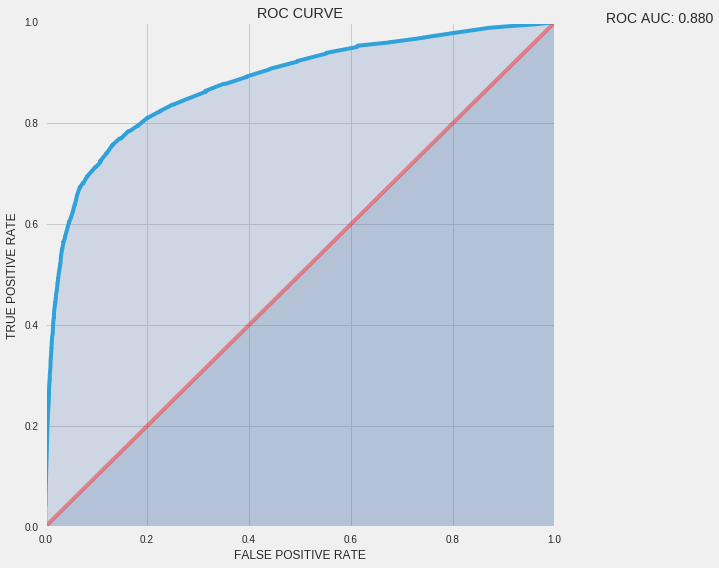

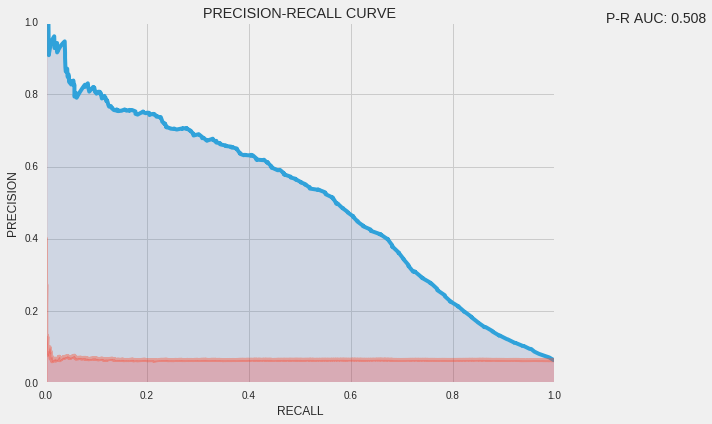

In [48]:
roc_pr(y_holdout, rfc_prob)

# IMPORTANT FEATURES

In [61]:
def plot_important_features(est, X, save_plot=False, plot_name='feature_importances.png'):
    '''
    INPUTS: Model, feature matrix
    OPTIONAL INPUTS: Show a plot, save the plot (BOOLEAN)
    OUTPUT: 
    '''
    features = X.columns
    importances = est.feature_importances_
    std = np.std([tree.feature_importances_ for tree in est.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    with plt.style.context('fivethirtyeight'):
        # Plot the feature importances of the forest
        plt.figure(figsize=(14, 8))
        plt.suptitle('FEATURE IMPORTANCES', fontsize=20, y=1.05)
        plt.bar(np.arange(X.shape[1]), importances[indices],
               color="r", alpha=.8, yerr=std[indices], align="center")
        plt.xticks(np.arange(X.shape[1]), features[indices], rotation='vertical')
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.xlabel('FEATURES', fontsize=14)
        plt.ylabel('IMPORTANCES', fontsize=14)
        plt.xlim([-1, X.shape[1]])
        if save_plot:
            plt.savefig('images/{}'.format(plot_name), bbox_inches='tight')

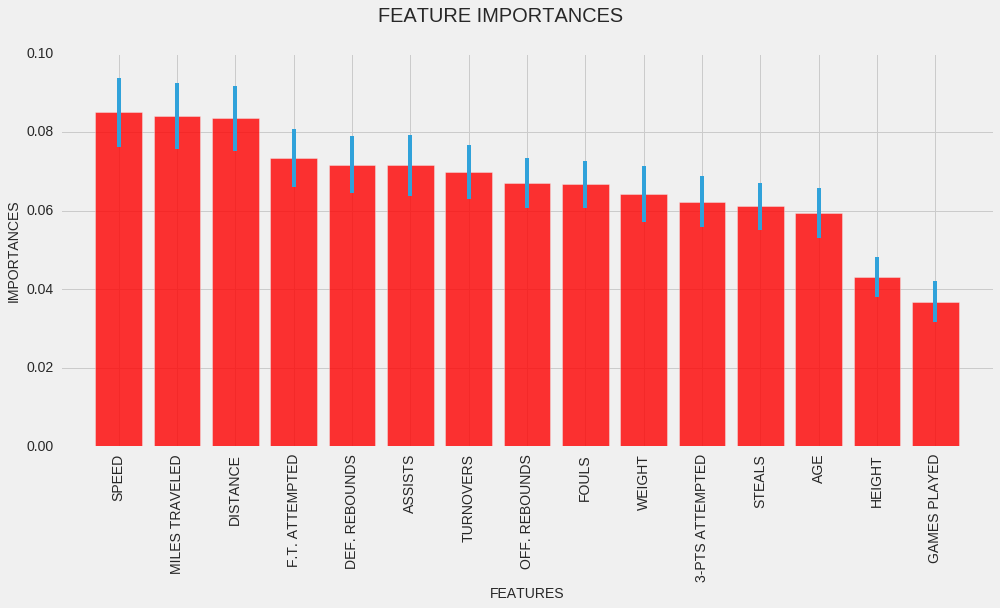

In [62]:
plot_important_features(rfc, X, True)

# PR-CURVE COMPARISON

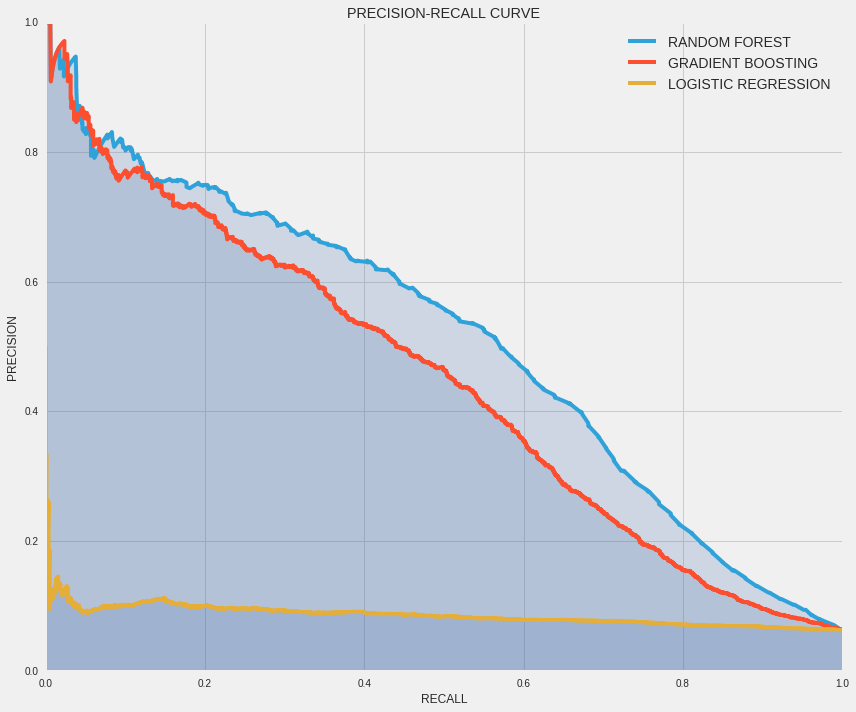

In [50]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12, 10))

    for name, probs in zip(['RANDOM FOREST', 'GRADIENT BOOSTING', 'LOGISTIC REGRESSION'], [rfc_prob, gbc_prob, logreg_prob]):    
        fpr, tpr, thres1 = roc_curve(y_holdout, probs)
        random_prob = np.random.random(y_holdout.shape[0])
        random_precision, random_recall, thres2 = precision_recall_curve(y_holdout, random_prob)
        precision, recall, thres2 = precision_recall_curve(y_holdout, probs)
        plt.plot(recall, precision, label=name)
        plt.fill_between(recall, 0, precision, alpha=.2)
        plt.title('PRECISION-RECALL CURVE')
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.legend(fontsize=14)
    plt.savefig('images/combined_curve.png')

# F1, RECALL, PRECISION VS THRESHOLD

In [27]:
thresholds = np.linspace(0, 1, 100)
preds = [rfc_prob > threshold for threshold in thresholds]

f1_scores = [f1_score(y_holdout, pred) for pred in preds]
precision_scores = [precision_score(y_holdout, pred) for pred in preds]
recall_scores = [recall_score(y_holdout, pred) for pred in preds]

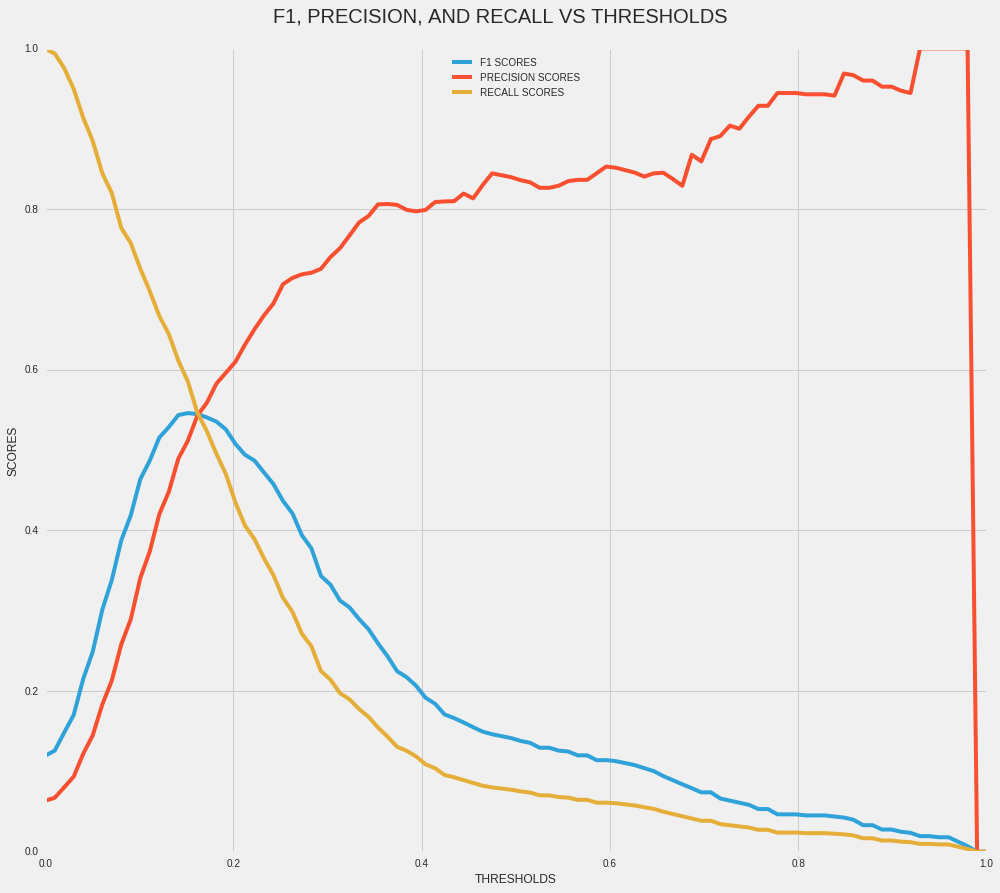

In [29]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(14, 12))
    plt.plot(thresholds, f1_scores, label='F1 SCORES')
    plt.plot(thresholds, precision_scores, label='PRECISION SCORES')
    plt.plot(thresholds, recall_scores, label='RECALL SCORES')
    plt.suptitle('F1, PRECISION, AND RECALL VS THRESHOLDS', fontsize=20, y=1.03)
    plt.xlabel('THRESHOLDS')
    plt.ylabel('SCORES')
    plt.legend(loc='best')
    plt.savefig('images/f1_p_r_curves', bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe37ba307d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe371083810>]], dtype=object)

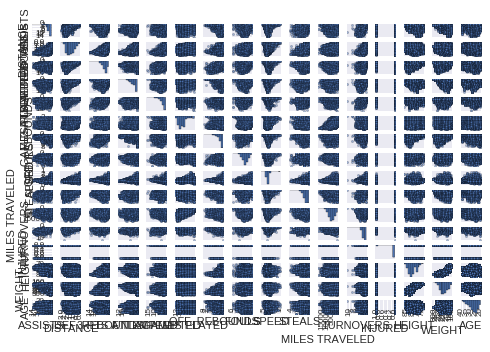

In [72]:
pd.scatter_matrix(Xy, figsize=(20, 20));